# DataJoint Elements for Optogenetics

#### Open-source data pipeline for processing and analyzing optogenetics datasets.

Welcome to the tutorial for the DataJoint Element for optogenetics. This
tutorial aims to provide a comprehensive understanding of the open-source data pipeline
created using `element-optogenetics`.

This package is designed to seamlessly ingest and track optogenetics data. By the end of this
tutorial you will have a clear grasp on setting up and integrating `element-optogenetics`
into your specific research projects and lab. 

![flowchart](../images/flowchart.svg)

### Prerequisites

Please see the [datajoint tutorials GitHub
repository](https://github.com/datajoint/datajoint-tutorials/tree/main) before
proceeding. 

#### **Tutorial Overview**

+ Setup
+ *Activate* the DataJoint pipeline.
+ *Insert* subject, session, surgery metadata.
+ *Insert* optogenetics recording data.
+ Query and view data

### **Setup**

This tutorial examines DataJoint tables that track optogenetics data. The goal is to store, track
and manage all metadata associated with optogenetics experiments, including surgical
implanation data. 

The results of this Element can be combined with **other modalities** to create
a complete, customizable data pipeline for your specific lab or study. For instance, you
can combine `element-optogenetics` with `element-array-ephys` and
`element-event` to characterize the neural activity during specific optogenetic stimulus
events.

Let's start this tutorial by importing the packages necessary to run the notebook.

In [1]:
import datajoint as dj

If the tutorial is run in Codespaces, a private, local database server is created and
made available for you. This is where we will insert and store our processed results.
Let's connect to the database server.

In [2]:
dj.conn()

[2024-01-17 12:35:14,558][INFO]: Connecting root@fakeservices.datajoint.io:3306
[2024-01-17 12:35:14,571][INFO]: Connected root@fakeservices.datajoint.io:3306


DataJoint connection (connected) root@fakeservices.datajoint.io:3306

### **Activate the DataJoint Pipeline**

This tutorial activates the `optogenetics.py` module from `element-optogenetics`, along
with upstream dependencies from `element-animal` and `element-session`. Please refer to the
[`tutorial_pipeline.py`](./tutorial_pipeline.py) for the source code.

In [3]:
from tutorial_pipeline import lab, subject, surgery, session, optogenetics, Device

[2024-01-17 12:35:14,756][WARNING]: lab.Project and related tables will be removed in a future version of Element Lab. Please use the project schema.


We can represent the tables in the `optogenetics` schemas as well as some of the
upstream dependencies to `session` and `subject` schemas as a diagram.

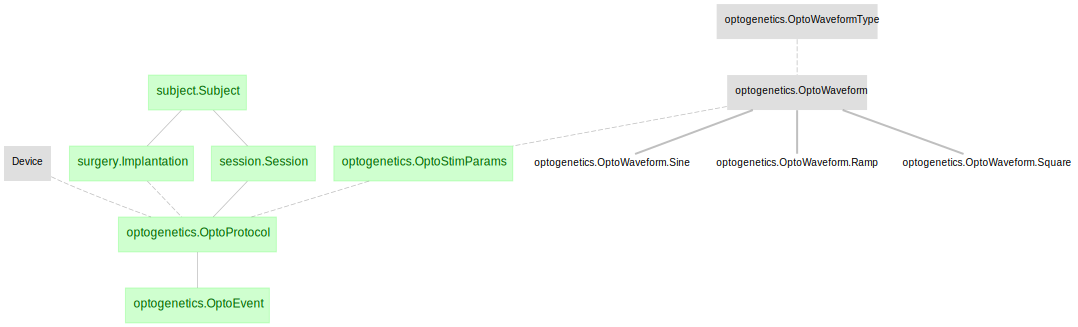

In [4]:
(
    dj.Diagram(subject.Subject)
    + dj.Diagram(surgery.Implantation)
    + dj.Diagram(session.Session)
    + dj.Diagram(Device)
    + dj.Diagram(optogenetics)
)

As evident from the diagram, this data pipeline encompasses tables associated with
optogenetic stimulation parameters, protocol, and events. A few tables, such as `subject.Subject` or `session.Session`,
while important for a complete pipeline, fall outside the scope of the `element-optogenetics`
tutorial, and will therefore, not be explored extensively here. The primary focus of
this tutorial will be on the `optogenetics` schemas.

### **Insert subject, surgery, and session metadata**

Let's start with the first table in the schema diagram (i.e. `subject.Subject` table).

To know what data to insert into the table, we can view its dependencies and attributes using the `.describe()` and `.heading` methods.

In [5]:
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description


In [6]:
print(subject.Subject.describe())

subject              : varchar(8)                   
---
subject_nickname=""  : varchar(64)                  
sex                  : enum('M','F','U')            
subject_birth_date   : date                         
subject_description="" : varchar(1024)                



In [7]:
subject.Subject.heading

# 
subject              : varchar(8)                   # 
---
subject_nickname=""  : varchar(64)                  # 
sex                  : enum('M','F','U')            # 
subject_birth_date   : date                         # 
subject_description="" : varchar(1024)                # 

The cells above show all attributes of the subject table.
We will insert data into the
`subject.Subject` table. 

In [8]:
subject.Subject.insert1(
    dict(
        subject="subject1",
        sex="F",
        subject_birth_date="2020-01-01",
        subject_description="Optogenetic pilot subject",
    )
)
subject.Subject()

subject,subject_nickname,sex,subject_birth_date,subject_description
subject1,,F,2020-01-01,Optogenetic pilot subject


Let's repeat the steps above for the `Session` table and see how the output varies between
`.describe` and `.heading`.

In [9]:
print(session.Session.describe())

-> subject.Subject
session_id           : int                          
---
session_datetime=null : datetime                     



In [10]:
session.Session.heading

# 
subject              : varchar(8)                   # 
session_id           : int                          # 
---
session_datetime=null : datetime                     # 

Notice that `describe`, displays the table's structure and highlights its dependencies, such as its reliance on the `Subject` table. These dependencies represent foreign key references, linking data across tables.

On the other hand, `heading` provides an exhaustive list of the table's attributes. This
list includes both the attributes declared in this table and any inherited from upstream
tables.

With this understanding, let's move on to insert a session associated with our subject.

We will insert into the `session.Session` table by passing a dictionary to the `insert1` method.

In [11]:
session_key = dict(subject="subject1", session_id=0, session_datetime="2023-01-01 00:00:00")

In [12]:
session.Session.insert1(session_key)
session.Session()

subject,session_id,session_datetime
subject1,0,2023-01-01 00:00:00


As the Diagram indicates, the `OptoProtocol` table requires an entry in both `Session`
and `Device` tables. Let's insert into the `Device` table.

In [13]:
Device.insert1(
    dict(
        device="OPTG_8",
        modality="Optogenetics",
        description="8 channel pulse sequence device",
    )
)
Device()

device,modality,description
OPTG_4,Optogenetics,Doric Pulse Sequence Generator
OPTG_8,Optogenetics,8 channel pulse sequence device


In [14]:
print(surgery.Implantation.describe())

-> subject.Subject
implant_date         : datetime                     # surgery date
-> surgery.ImplantationType
-> surgery.BrainRegion.proj(target_region="region_acronym")
-> surgery.Hemisphere.proj(target_hemisphere="hemisphere")
---
-> lab.User.proj(surgeon="user")
implant_comment=""   : varchar(1024)                # Comments about the implant



The `surgery.Implantation` table's attribute includes the `User` table. Let's insert
into the `User` table.

In [15]:
lab.User.insert1(dict(user="User1"))
lab.User()

"user username, short identifier",user_email,user_cellphone,user_fullname Full name used to uniquely identify an individual
User1,,,


The `Implantation` table's attributes includes the `CoordinateReference` and `Hemisphere` tables.  Let's view the contents of these lookup tables, which have default contents.

In [16]:
surgery.CoordinateReference()

reference
bregma
dura
lambda
sagittal_suture
sinus
skull_surface


In [17]:
surgery.Hemisphere()

hemisphere Brain region hemisphere
left
middle
right


Insert a new entry for the location of the optogenetics probe.

In [18]:
surgery.BrainRegion.insert1(
    dict(region_acronym="dHP", region_name="Dorsal Hippocampus")
)
surgery.BrainRegion()

region_acronym Brain region shorthand,region_name Brain region full name
dHP,Dorsal Hippocampus


In [19]:
surgery.Implantation.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        surgeon="User1",
    )
)
surgery.Implantation.Coordinate.insert1(
    dict(
        subject="subject1",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        ap="-7.9",  # [mm] anterior-posterior distance
        ap_ref="bregma",
        ml="-1.8",  # [mm] medial axis distance
        ml_ref="bregma",
        dv="5",  # [mm] dorso-ventral axis distance
        dv_ref="skull_surface",
        theta="11.5",  # [0, 180] degree rotation about ml-axis relative to z
        phi="0",  # [0, 360] degree rotation about dv-axis relative to x
        beta=None,  # [-180, 180] degree rotation about shank relative to anterior
    )
)

Confirm the inserted information:

In [20]:
surgery.Implantation()

subject,implant_date surgery date,implant_type Short name for type of implanted device,target_region Brain region shorthand,target_hemisphere Brain region hemisphere,"surgeon username, short identifier",implant_comment Comments about the implant
subject1,2022-04-01 12:13:14,opto,dHP,left,User1,


In [21]:
surgery.Implantation.Coordinate()

subject,implant_date surgery date,implant_type Short name for type of implanted device,target_region Brain region shorthand,target_hemisphere Brain region hemisphere,ap (mm) anterior-posterior; ref is 0,ap_ref,ml (mm) medial axis; ref is 0,ml_ref,dv (mm) dorso-ventral axis; ventral negative,dv_ref,"theta (deg) rot about ml-axis [0, 180] wrt z","phi (deg) rot about dv-axis [0, 360] wrt x","beta (deg) rot about shank [-180, 180] wrt anterior"
subject1,2022-04-01 12:13:14,opto,dHP,left,-7.9,bregma,-1.8,bregma,5.0,skull_surface,11.5,0.0,nan


We'll add information to describe the stimulus, including waveform shape and stimulation parameters.

In [22]:
optogenetics.OptoWaveform.insert1(
    dict(
        waveform_name="square_10",
        waveform_type="square",
        waveform_description="Square waveform: 10%/90% on/off cycle",
    )
)

# Square is one part table of OptoWaveform.
# For sine and ramp waveforms, see the corresponding tables.
optogenetics.OptoWaveform.Square.insert1(
    dict(waveform_name="square_10", on_proportion=0.10, off_proportion=0.90)
)

In [23]:
optogenetics.OptoStimParams.insert1(
    dict(
        opto_params_id=1,
        waveform_name="square_10",
        wavelength=470,
        light_intensity=10.2,
        frequency=1,
        duration=241,
    )
)
optogenetics.OptoStimParams()

opto_params_id,waveform_name,wavelength (nm) wavelength of optical stimulation light,power (mW) total power from light source,light_intensity (mW/mm2) power for given area,frequency (Hz) frequency of the waveform,duration (ms) duration of each optical stimulus
1,square_10,470,None,10.20,1.0,241.0


### **Insert optogenetics recording data**
Next, we'll describe the session in which these parameters are used in `OptoProtocol`.

In [24]:
optogenetics.OptoProtocol.insert1(
    dict(
        subject="subject1",
        session_id="0",
        protocol_id="1",
        opto_params_id="1",
        implant_date="2022-04-01 12:13:14",
        implant_type="opto",
        target_region="dHP",
        target_hemisphere="left",
        device="OPTG_4",
    )
)
optogenetics.OptoProtocol()

subject,session_id,protocol_id,opto_params_id,implant_date surgery date,implant_type Short name for type of implanted device,target_region Brain region shorthand,target_hemisphere Brain region hemisphere,device,protocol_description description of optogenetics protocol
subject1,0,1,1,2022-04-01 12:13:14,opto,dHP,left,OPTG_4,


We can describe the timing of these stimulations in `OptoEvent`.

In [25]:
optogenetics.OptoEvent.insert1(
    dict(
        subject="subject1",
        session_id=0,
        protocol_id=1,
        stim_start_time=241,
        stim_end_time=482,
    )
)
optogenetics.OptoEvent()

subject,session_id,protocol_id,stim_start_time (s) stimulus start time relative to session start,stim_end_time (s) stimulus end time relative session start
subject1,0,1,241.0,482.0


We can insert a second set of timing information for the stimulation.

In [26]:
optogenetics.OptoEvent.insert1(
    dict(
        subject="subject1",
        session_id=0,
        protocol_id=1,
        stim_start_time=543,
        stim_end_time=797,
    )
)
optogenetics.OptoEvent()

subject,session_id,protocol_id,stim_start_time (s) stimulus start time relative to session start,stim_end_time (s) stimulus end time relative session start
subject1,0,1,241.0,482.0
subject1,0,1,543.0,797.0


### **Query and view data**

Queries allow you to view the contents of the database.  The simplest query is the
instance of the table class.

In [27]:
optogenetics.OptoEvent()

subject,session_id,protocol_id,stim_start_time (s) stimulus start time relative to session start,stim_end_time (s) stimulus end time relative session start
subject1,0,1,241.0,482.0
subject1,0,1,543.0,797.0


With the `&` operator, we will restrict the contents of the `OptoEvent` table to those entries with a `stim_start_time` of 543.

In [28]:
optogenetics.OptoEvent & "stim_start_time=543"

subject,session_id,protocol_id,stim_start_time (s) stimulus start time relative to session start,stim_end_time (s) stimulus end time relative session start
subject1,0,1,543.0,797.0


DataJoint queries can be a highly flexible tool with several [operators](https://datajoint.com/docs/core/concepts/query-lang/operators/).  The next operator we will explore is `join` which combines matching information from tables.

In [29]:
optogenetics.OptoProtocol * optogenetics.OptoStimParams

subject,session_id,protocol_id,opto_params_id,implant_date surgery date,implant_type Short name for type of implanted device,target_region Brain region shorthand,target_hemisphere Brain region hemisphere,device,protocol_description description of optogenetics protocol,waveform_name,wavelength (nm) wavelength of optical stimulation light,power (mW) total power from light source,light_intensity (mW/mm2) power for given area,frequency (Hz) frequency of the waveform,duration (ms) duration of each optical stimulus
subject1,0,1,1,2022-04-01 12:13:14,opto,dHP,left,OPTG_4,,square_10,470,None,10.20,1.0,241.0


The `fetch` and `fetch1` methods download the data from the query object into the workspace.

Below we will run `fetch()` without any arguments to return all attributes of all entries in the table.

In [30]:
optogenetics.OptoEvent.fetch(as_dict=True)

[{'subject': 'subject1',
  'session_id': 0,
  'protocol_id': 1,
  'stim_start_time': 241.0,
  'stim_end_time': 482.0},
 {'subject': 'subject1',
  'session_id': 0,
  'protocol_id': 1,
  'stim_start_time': 543.0,
  'stim_end_time': 797.0}]

Next, we will fetch the entry with a `stim_start_time` of 543 with the `fetch1` method, which returns a dictionary containing all attributes of one entry in the table.

In [31]:
(optogenetics.OptoEvent & "stim_start_time=543").fetch1()

{'subject': 'subject1',
 'session_id': 0,
 'protocol_id': 1,
 'stim_start_time': 543.0,
 'stim_end_time': 797.0}

## Summary

Following this tutorial, we have: 
+ Covered the essential functionality of `element-optogenetics`.
+ Learned how to manually insert data into tables.
+ Queried and viewed the data. 

#### Documentation and DataJoint Tutorials

+ [Detailed documentation on
  `element-optogenetics`.](https://datajoint.com/docs/elements/element-optogenetics/)
+ [General `datajoint-python`
  tutorials.](https://github.com/datajoint/datajoint-tutorials) covering fundamentals,
  such as table tiers, query operations, fetch operations, automated computations with the
  make function, and more.
+ [Documentation for
  `datajoint-python`.](https://datajoint.com/docs/core/datajoint-python/)

##### Run this tutorial on your own data

To run this tutorial notebook on your own data, please use the following steps:
+ Download the [mysql-docker image for
  DataJoint](https://github.com/datajoint/mysql-docker) and run the container according
  to the instructions provide in the repository.
+ Create a fork of this repository to your GitHub account.
+ Clone the repository and open the files using your IDE.
+ Add a code cell immediately after the first code cell in the notebook - we will setup
  the local connection using this cell. In this cell, type in the following code. 

```python
import datajoint as dj
dj.config["database.host"] = "localhost"
dj.config["database.user"] = "<your-username>"
dj.config["database.password"] = "<your-password>"
dj.config["custom"] = {"imaging_root_data_dir": "path/to/your/data/dir",
"database_prefix": "<your-username_>"}
dj.config.save_local()
dj.conn()
```

+ Run the code block above and proceed with the rest of the notebook.